In [1]:
import kagglehub
path = kagglehub.dataset_download("pkdarabi/diagnosis-of-diabetic-retinopathy")

print("Path to dataset files:", path)

100%|██████████| 30.1M/30.1M [00:03<00:00, 8.85MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pkdarabi/diagnosis-of-diabetic-retinopathy/versions/2


In [2]:
import os
os.listdir(path)

['Diagnosis of Diabetic Retinopathy', 'retino']

In [3]:
import os
base_dir = path
subdirs = [os.path.join(base_dir, d) for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
for subdir in subdirs:
    print(subdir)

/root/.cache/kagglehub/datasets/pkdarabi/diagnosis-of-diabetic-retinopathy/versions/2/Diagnosis of Diabetic Retinopathy
/root/.cache/kagglehub/datasets/pkdarabi/diagnosis-of-diabetic-retinopathy/versions/2/retino


In [4]:
ret_dir = os.path.join(path ,'retino')
print(ret_dir if os.path.isdir(ret_dir) else "Directory does not exist")

/root/.cache/kagglehub/datasets/pkdarabi/diagnosis-of-diabetic-retinopathy/versions/2/retino


# Prepare the data

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict
from pathlib import Path
def get_dataset_stats(base_dir: Path )-> Dict[str, int]:
    """
    Returns a dictionary containing image counts per class for train, valid, and test sets.
    """
    stats: Dict[str, int]= {}
    for subset in ["train", "valid", "test"]:
        subset_path = os.path.join(base_dir, subset)
        if os.path.isdir(subset_path):
            stats[subset] = {}
            for class_name in os.listdir(subset_path):
                class_path = os.path.join(subset_path, class_name)
                if os.path.isdir(class_path):
                    num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
                    stats[subset][class_name] = num_images
    return stats


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(stats: Dict[str, int])-> None:
    """
    Plots a grouped bar chart of class distributions for train, valid, and test sets with custom colors.
    """
    subsets = list(stats.keys())
    class_names = list(next(iter(stats.values())).keys())
    counts = {cls: [stats[subset].get(cls, 0) for subset in subsets] for cls in class_names}
    bar_width = 0.3
    x = np.arange(len(subsets))
    colors = ["navy", "magenta"]
    plt.figure(figsize=(10, 6))
    for i, (cls, values) in enumerate(counts.items()):
        plt.bar(x + i * bar_width, values, width=bar_width, label=cls, color=colors[i % len(colors)])
    plt.xlabel("Dataset Subset")
    plt.ylabel("Number of Images")
    plt.title("Class Distribution Across Dataset Subsets")
    plt.xticks(x + bar_width / 2, subsets)
    plt.legend(title="Class")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()


In [7]:
dataset_stats = get_dataset_stats(ret_dir)
print(dataset_stats)


{'train': {'No_DR': 1026, 'DR': 1050}, 'valid': {'No_DR': 286, 'DR': 245}, 'test': {'No_DR': 118, 'DR': 113}}


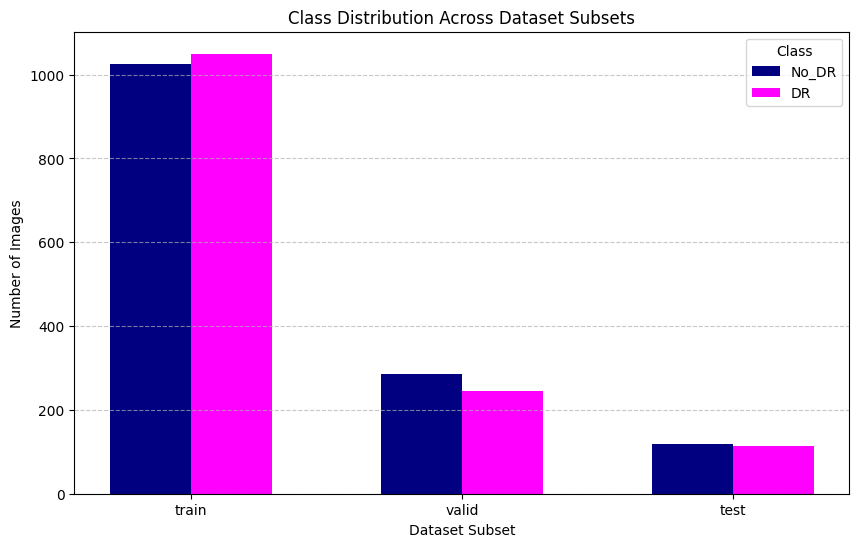

In [8]:
plot_class_distribution(dataset_stats)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np

## Summary of MobileNet Architecture

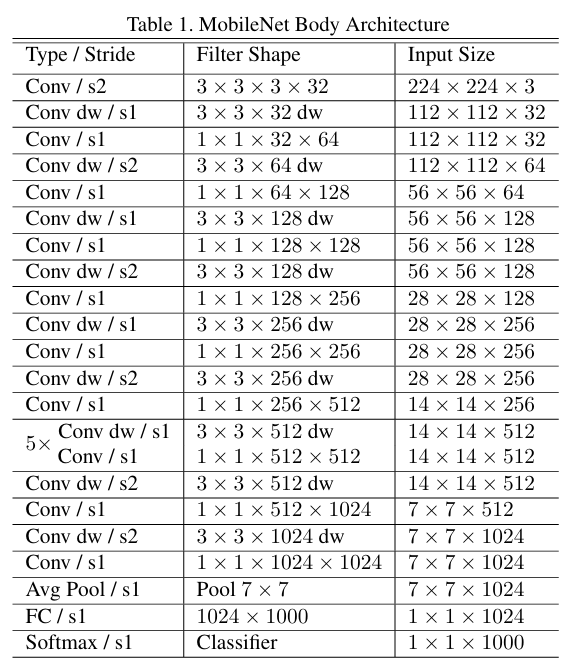

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # MobileNet's inp size is 224*224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [11]:
train_dir = os.path.join(ret_dir, 'train')
valid_dir = os.path.join(ret_dir, 'valid')
test_dir = os.path.join(ret_dir, 'test')

train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
valid_dataset = torchvision.datasets.ImageFolder(root=valid_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [12]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 2076
Validation dataset size: 531
Test dataset size: 231


In [13]:
num_train_batches = len(train_loader)
num_valid_batches = len(valid_loader)
num_test_batches = len(test_loader)

print(f"Number of batches in training set: {num_train_batches}")
print(f"Number of batches in validation set: {num_valid_batches}")
print(f"Number of batches in test set: {num_test_batches}")


Number of batches in training set: 65
Number of batches in validation set: 17
Number of batches in test set: 8


In [14]:
print(f"Classes: {train_dataset.classes}")
print(f"Class-to-Index Mapping: {train_dataset.class_to_idx}")

Classes: ['DR', 'No_DR']
Class-to-Index Mapping: {'DR': 0, 'No_DR': 1}


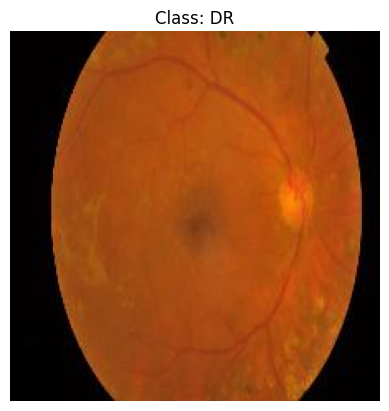

In [15]:
# here we check the loaders have been created successfully
image, label = train_dataset[1]
image = image.permute(1, 2, 0).numpy()  # change shape from (C, H, W) -> (H, W, C)
# Unnormalize
image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
image = np.clip(image, 0, 1)
plt.imshow(image)
plt.title(f"Class: {train_dataset.classes[label]}")
plt.axis("off")
plt.show()


In [16]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(f"Batch size: {images.shape}")
print(f"Labels: {labels}")


Batch size: torch.Size([32, 3, 224, 224])
Labels: tensor([0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1])


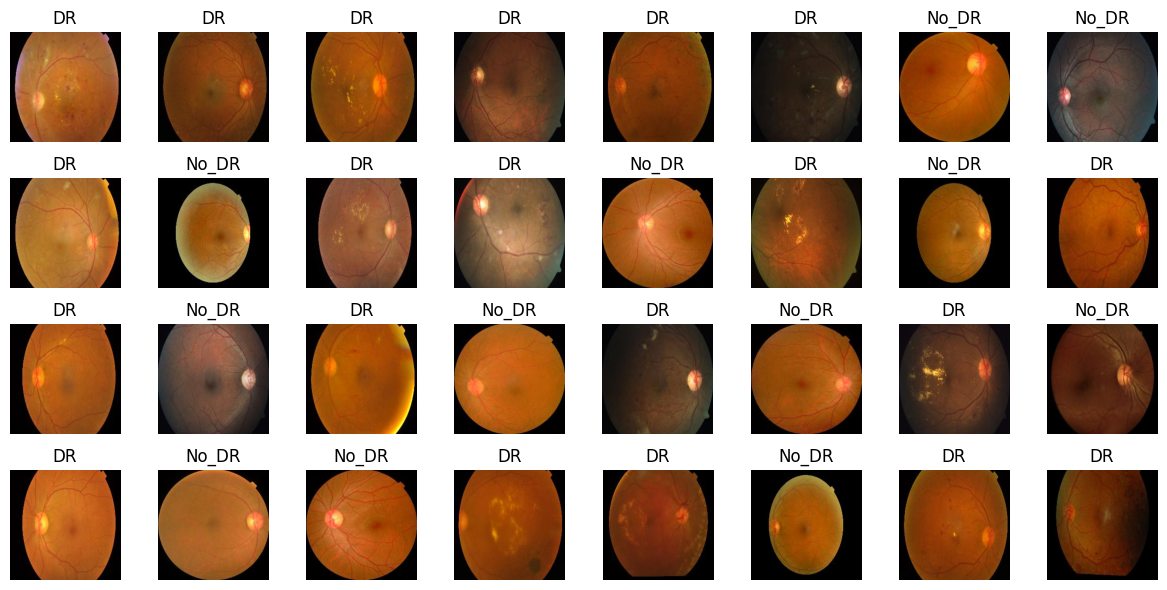

In [17]:
def show_batch(loader: DataLoader)-> None:
    """
    Check and visualise the training batch samples
    """
    dataiter = iter(loader)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(4, 8, figsize=(12, 6))  # 32 = 4r,8c
    axes = axes.flatten()
    for img, lbl, ax in zip(images, labels, axes):
        img = img.permute(1, 2, 0).numpy()  # convert to HWC format
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(train_dataset.classes[lbl.item()])
        ax.axis("off")
    plt.tight_layout()
    plt.show()
show_batch(train_loader)


# Loading the pretrained model

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet = mobilenet.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Using device: cuda


100%|██████████| 13.6M/13.6M [00:00<00:00, 218MB/s]


In [19]:
mobilenet.classifier[1] = nn.Linear(in_features=1280, out_features=2)
mobilenet = mobilenet.to(device)


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.parameters(), lr=0.0001)


In [21]:
import matplotlib.pyplot as plt
# training/val loop
train_losses = []
train_accuracies = []
valid_accuracies = []
num_epochs = 8

for epoch in range(num_epochs):
    mobilenet.train()
    running_loss = 0.0
    correct, total = 0, 0
    # training step
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = mobilenet(images)
        loss = criterion(outputs, labels)
        # back propagation
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # validation step
    mobilenet.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = mobilenet(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    valid_acc = 100 * correct / total
    valid_accuracies.append(valid_acc)
    print(f"[Epoch {epoch+1}/{num_epochs}]\n Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.2f}% | Valid Acc: {valid_acc:.2f}%")
    print("_"*70)



[Epoch 1/8]
 Train Loss: 0.1796 | Train Acc: 93.79% | Valid Acc: 96.61%
______________________________________________________________________
[Epoch 2/8]
 Train Loss: 0.0595 | Train Acc: 98.07% | Valid Acc: 97.74%
______________________________________________________________________
[Epoch 3/8]
 Train Loss: 0.0311 | Train Acc: 98.65% | Valid Acc: 96.99%
______________________________________________________________________
[Epoch 4/8]
 Train Loss: 0.0180 | Train Acc: 99.47% | Valid Acc: 96.42%
______________________________________________________________________
[Epoch 5/8]
 Train Loss: 0.0110 | Train Acc: 99.76% | Valid Acc: 96.42%
______________________________________________________________________
[Epoch 6/8]
 Train Loss: 0.0048 | Train Acc: 99.86% | Valid Acc: 96.99%
______________________________________________________________________
[Epoch 7/8]
 Train Loss: 0.0025 | Train Acc: 99.95% | Valid Acc: 96.61%
______________________________________________________________________

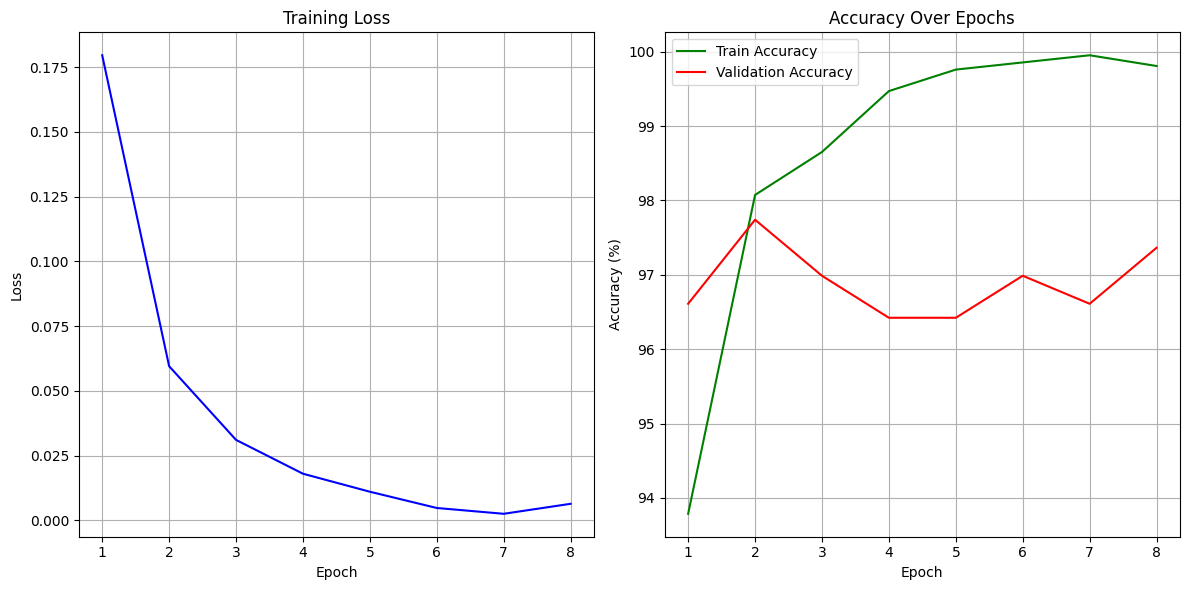

In [22]:
# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy", color='green')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label="Validation Accuracy", color='red')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()


In [23]:
mobilenet.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = mobilenet(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 96.97%


In [24]:
# Ensure CUDA is completely disabled
torch.cuda.is_available = lambda: False  # Monkey patch to prevent CUDA usage

# Load or define the model
mobilenet.eval()  # Set the model to evaluation mode
mobilenet.to("cpu")  # Ensure the model is on CPU

# Verify all parameters are on CPU
for param in mobilenet.parameters():
    assert param.device.type == "cpu", "Error: Model contains parameters on GPU!"


# Create an example input tensor on CPU
example_input = torch.randn(1, 3, 224, 224)  # No `.to("cuda")` calls

# Test inference to ensure CPU-only execution
with torch.no_grad():
    output = mobilenet(example_input)
print("CPU-only inference successful!")

# Trace the model using TorchScript
traced_model = torch.jit.trace(mobilenet, example_input)

# Save the traced model
traced_model.save("mobilenet_cpu_only.pt")


CPU-only inference successful!


`torch.jit.trace` is used to convert your PyTorch model into TorchScript, a way to optimize and serialize the model for deployment. TorchScript allows the model to be run independently of Python, making it suitable for mobile and production environments.
  - Tracing: This method traces the model's operations by running it on the provided example input (the dummy tensor). It records the operations performed during this forward pass and generates a representation of those operations that can be saved and executed without the Python runtime.


```
val module = LiteModuleLoader.load(assetFilePath(context, "mobilenet_diabetic_retinopathy.pt"))
val inputTensor = TensorImageUtils.bitmapToFloat32Tensor(bitmap, mean, std)
val outputTensor = module.forward(IValue.from(inputTensor)).toTensor()
val scores = outputTensor.dataAsFloatArray

```